### IMPORTS

In [1]:
import numpy as np
from Meshing.Meshing import *
from Fields.Fields import *
from Kernels.Kernels import *
from Solvers.Solvers import *
from Subchannel.FluidRelation import FluidRelation
from Subchannel.Channel import Channel
from Subchannel.Channel import ChannelInterface
from Subchannel.Channel import ChannelArray
from Aux.CSVObjects import *
from Aux.ReactorPhysicsObjects import *



### ST.ST. THERMAL HYDRAULICS

In [2]:
_dt = 1e321
Lambda = 3.11e-4
gravity = 9.81
Dh = 0.0158276279311347000000
perim = 0.07267978843558340
area = 2.572980283E-04
temp_tolerance = 1e-10
max_temp_iterations = 1000
nZones=25
L0 = 0.0
L1 = 67*2.54/100
fluid = FluidRelation(cp=1983, mu=0.00744, k=1.44, rho_0 = 2715.13, drho_dT=-0.513)
pressure_bc = 0.0
T_bc = 900.0
MDOT_MAX = 0.120101854 * 3.0
fric = 'type1'
heat_source = [0.0]*nZones # heat source in W/m3

upper_plenum_area = 1.065948974E-04 * 3.0
lower_plenum_area = 1.065948974E-04* 3.0
external_loop_area =6.810652553E-04* 3.0

# Change mdot based on csv values:
mdot_csv = load_csv('Data/mass_flow_startup.csv')
mdot_bc_total = MDOT_MAX / 100 * csv_interpolator(csv_df=mdot_csv, x_value=0.0, x_label='time', y_label='mdot')
flow_ratios = np.array([1.6, 0.9, 1.0]) # how flow is distributed ( no normalization required - noramlized every time mdots are computed.)
# fuel_ratio = 0.1279 + 0.3069 + 0.4178 # radial power peaking weighting factors v- aka % of rx power with the given flow rates.
#################
# CHANNEL SETUPS
#################
ch_1 = Channel(gravity=gravity,
             Dh=Dh,
             area=area,
             temp_tolerance=temp_tolerance,
             max_temp_iterations=max_temp_iterations,
             nZones=nZones,
             L0=L0,
             L1=L1,
             fluid=fluid,
             pressure_bc=pressure_bc,
             T_bc=T_bc,
             mdot_bc=1.0,
             fric=fric,
             heat_source=heat_source)
ch_2 = Channel(gravity=gravity,
             Dh=Dh,
             area=area,
             temp_tolerance=temp_tolerance,
             max_temp_iterations=max_temp_iterations,
             nZones=nZones,
             L0=L0,
             L1=L1,
             fluid=fluid,
             pressure_bc=pressure_bc,
             T_bc=T_bc,
             mdot_bc=1.0,
             fric=fric,
             heat_source=heat_source)
ch_3 = Channel(gravity=gravity,
             Dh=Dh,
             area=area,
             temp_tolerance=temp_tolerance,
             max_temp_iterations=max_temp_iterations,
             nZones=nZones,
             L0=L0,
             L1=L1,
             fluid=fluid,
             pressure_bc=pressure_bc,
             T_bc=T_bc,
             mdot_bc=1.0,
             fric=fric,
             heat_source=heat_source)

ch = ChannelArray(channels=[ch_1, ch_2, ch_3],
                  coupling_method='ratio_method',
                  flow_ratios=flow_ratios,
                  fluid=fluid)

# VERY important to update this guy since
# this object updates internally the individual channels
# in the channel array
ch.mdot_bc = MDOT_MAX

upper_plenum = Channel(gravity=gravity,
                       Dh=Dh,
                       area=upper_plenum_area,
                       temp_tolerance=temp_tolerance,
                       max_temp_iterations=max_temp_iterations,
                       nZones=nZones,
                       L0=0.0,
                       L1=1.0,
                       fluid=fluid,
                       pressure_bc=pressure_bc,
                       T_bc=1.0,
                       mdot_bc=1.0,
                       fric='none',
                       heat_source=0.0)

external_loop = Channel(gravity=gravity,
                       Dh=Dh,
                       area=external_loop_area,
                       temp_tolerance=temp_tolerance,
                       max_temp_iterations=max_temp_iterations,
                       nZones=nZones,
                       L0=0.0,
                       L1=1.0,
                       fluid=fluid,
                       pressure_bc=pressure_bc,
                       T_bc=1.0,
                       mdot_bc=1.0,
                       fric='none',
                       heat_source=0.0)

lower_plenum = Channel(gravity=gravity,
                       Dh=Dh,
                       area=lower_plenum_area,
                       temp_tolerance=temp_tolerance,
                       max_temp_iterations=max_temp_iterations,
                       nZones=nZones,
                       L0=0.0,
                       L1=1.0,
                       fluid=fluid,
                       pressure_bc=pressure_bc,
                       T_bc=1.0,
                       mdot_bc=1.0,
                       fric='none',
                       heat_source=0.0)

# Interfaces to handle data passing from one channel to another.
ch_to_up = ChannelInterface(ch1=ch, ch2=upper_plenum)
up_to_ex = ChannelInterface(ch1=upper_plenum, ch2=external_loop)
ex_to_lp = ChannelInterface(ch1=external_loop, ch2=lower_plenum)
lp_to_ch = ChannelInterface(ch1=lower_plenum, ch2=ch)

# Solution order - main channel -> plenum -> external loop -> lower plenum -> main channel
ch.solve_channel_TH(_dt=_dt)
ch_to_up.update_interface_conditions(tracer_bool=False, th_bool=True)

upper_plenum.solve_channel_TH(_dt=_dt)
up_to_ex.update_interface_conditions(tracer_bool=False, th_bool=True)

external_loop.solve_channel_TH(_dt=_dt)
ex_to_lp.update_interface_conditions(tracer_bool=False, th_bool=True)

lower_plenum.solve_channel_TH(_dt=_dt)
lp_to_ch.update_interface_conditions(tracer_bool=False, th_bool=True)

# End
print(ch.get_channel_residence_time())
print(upper_plenum.get_channel_residence_time())
print(external_loop.get_channel_residence_time())
print(lower_plenum.get_channel_residence_time())


8.741754430744814
2.0000035940168077
12.77859439414382
2.0000035940168077


### STEADY STATE TRACERS

In [3]:
# source ratios
lp_ratio = 0.0859 + 0.0226
up_ratio = 0.0389
# total fuel fission source in  all channels:
fuel_ratio = 0.1279 + 0.3069 + 0.4178
# ch_ratio_1 = fuel_ratio / 3.0
# ch_ratio_2 = fuel_ratio / 3.0
# ch_ratio_3 = fuel_ratio / 3.0
ch_ratio_1 = 0.1279
ch_ratio_2 = 0.3069
ch_ratio_3 = 0.4178

tracer_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6']
initial_value_tracers = 0.0
scheme_tracers = 'upwind'

# OPENMC DNP DATA
decay_consts = [0.01334, 0.03273, 0.1208, 0.3029, 0.8498, 2.854]
beta = [0.000228, 0.001177, 0.001124, 0.002522, 0.001036, 0.000434]

# JEFF DATA
# decay_consts = [0.0125, 0.0283, 0.0425, 0.1330, 0.2925, 0.6665, 1.6345, 3.5546]
# beta = [22.42e-5, 109.13e-5, 63.13e-5, 140.22e-5, 232.39e-5, 64.07e-5, 58.32e-5, 16.70e-5]

# SINGH ET AL NONLINEAR DYNAMIC MODEL
# decay_consts = [0.0124, 0.0305, 0.111, 0.301, 1.14, 3.01]
# beta = [2.23e-4, 14.57e-4, 13.07e-4, 26.28e-4, 7.66e-4, 2.80e-4]

boundary = 'lower' # must be lower anyways
phi_tracer = 1.0
rho_tracer = 1.0

# MAKE SOURCES FOR FISSION SOURCE / IMPORTANCE WEIGHTING
src_function = np.cos(np.pi * ( np.array(ch_1.mesh.centroids) -L1/2) / (L1*1.15))
fsrc_1 =   ScalarField(name='fsrc',   initial_value=src_function,    mesh=ch_1.mesh)
fsrc_2 =   ScalarField(name='fsrc',   initial_value=src_function,    mesh=ch_1.mesh)
fsrc_3 =   ScalarField(name='fsrc',   initial_value=src_function,    mesh=ch_1.mesh)
up_src = ScalarField(name='up_pre', initial_value=np.ones(nZones), mesh=upper_plenum.mesh)
lp_src = ScalarField(name='lp_pre', initial_value=np.ones(nZones), mesh=lower_plenum.mesh)

ch1_src_int = fsrc_1.field_volume_integral()
ch2_src_int = fsrc_2.field_volume_integral()
ch3_src_int = fsrc_3.field_volume_integral()
up_src_int = up_src.field_volume_integral()
lp_src_int = lp_src.field_volume_integral()
total_int = ch1_src_int + ch2_src_int + ch3_src_int + up_src_int + lp_src_int

fsrc_1.T = copy.deepcopy(fsrc_1.T)     * ch_ratio_1 / ch1_src_int
fsrc_2.T = copy.deepcopy(fsrc_2.T)     * ch_ratio_2 / ch1_src_int
fsrc_3.T = copy.deepcopy(fsrc_3.T)     * ch_ratio_3 / ch1_src_int
up_src.T = up_src.T * up_ratio / up_src_int
lp_src.T = lp_src.T * lp_ratio / lp_src_int

print("CHANNEL 1 SRC FRAC", fsrc_1.field_volume_integral())
print("CHANNEL 2 SRC FRAC", fsrc_2.field_volume_integral())
print("CHANNEL 3 SRC FRAC", fsrc_3.field_volume_integral())
print("UPPER PLENUM SRC FRAC", up_src.field_volume_integral())
print("LOWER PLENUM SRC FRAC", lp_src.field_volume_integral())
print("TOTAL SRC FRAC", fsrc_1.field_volume_integral() + fsrc_2.field_volume_integral() + fsrc_3.field_volume_integral()
                        + up_src.field_volume_integral() + lp_src.field_volume_integral())

# TRACER SETUP IN MAIN CHANNEL
for idx, name in enumerate(tracer_names):
  ch.channels[0].add_tracer_to_channel(name=tracer_names[idx], initial_value=initial_value_tracers,
                          scheme=scheme_tracers, decay_const=decay_consts[idx],
                          boundary=boundary, phi=phi_tracer, rho=rho_tracer, source=fsrc_1, beta=beta[idx])
  ch.channels[1].add_tracer_to_channel(name=tracer_names[idx], initial_value=initial_value_tracers,
                          scheme=scheme_tracers, decay_const=decay_consts[idx],
                          boundary=boundary, phi=phi_tracer, rho=rho_tracer, source=fsrc_2, beta=beta[idx])
  ch.channels[2].add_tracer_to_channel(name=tracer_names[idx], initial_value=initial_value_tracers,
                          scheme=scheme_tracers, decay_const=decay_consts[idx],
                          boundary=boundary, phi=phi_tracer, rho=rho_tracer, source=fsrc_3, beta=beta[idx])


# TRACER SETUP IN UPPER PLENUM
for idx, name in enumerate(tracer_names):
  upper_plenum.add_tracer_to_channel(name=tracer_names[idx], initial_value=0.0,
                                     scheme=scheme_tracers, decay_const=decay_consts[idx],
                                     boundary=boundary, phi=phi_tracer,rho=rho_tracer,source=up_src, beta=beta[idx])

# TRACER SETUP IN EXTERNAL LOOP
for idx, name in enumerate(tracer_names):
  external_loop.add_tracer_to_channel(name=tracer_names[idx], initial_value=0.0,
                                     scheme=scheme_tracers, decay_const=decay_consts[idx],
                                     boundary=boundary, phi=phi_tracer,rho=rho_tracer,source=0.0, beta=beta[idx])

# TRACER SETUP IN LOWER PLENUM
for idx, name in enumerate(tracer_names):
  lower_plenum.add_tracer_to_channel(name=tracer_names[idx], initial_value=0.0,
                                     scheme=scheme_tracers, decay_const=decay_consts[idx],
                                     boundary=boundary, phi=phi_tracer,rho=rho_tracer,source=lp_src, beta=beta[idx])

# TRACER SOLVE LOOP
ch_outlet_value = 1
while True:
  ch.solve_all_tracers(_dt=_dt)
  ch_to_up.update_interface_conditions(tracer_bool=True, th_bool=False)

  upper_plenum.solve_all_tracers(_dt=_dt)
  up_to_ex.update_interface_conditions(tracer_bool=True, th_bool=False)

  external_loop.solve_all_tracers(_dt=_dt)
  ex_to_lp.update_interface_conditions(tracer_bool=True, th_bool=False)

  lower_plenum.solve_all_tracers(_dt=_dt)
  lp_to_ch.update_interface_conditions(tracer_bool=True,th_bool=False)

  _,_,_,_,tracer_outlet_weighted_value = ch.get_outlet_conditions()
  diff = np.abs(ch_outlet_value - tracer_outlet_weighted_value['c6'])

  print(diff)

  ch_outlet_value = tracer_outlet_weighted_value['c6']

  if diff < 1e-12:
    break




CHANNEL 1 SRC FRAC 0.12789999999999999
CHANNEL 2 SRC FRAC 0.30690000000000006
CHANNEL 3 SRC FRAC 0.4178
UPPER PLENUM SRC FRAC 0.03889999999999999
LOWER PLENUM SRC FRAC 0.10849999999999994
TOTAL SRC FRAC 0.9999999999999999
0.9557854494970495
9.56798926775304e-07
0.0


### RUN TRANSIENT

In [ ]:
# Time settings
Tstart = -2
Tend = 50
nsteps = 5000

# Timesteps
timesteps = np.linspace(Tstart, Tend, nsteps)

# Update old values in channel before starting simulation
ch.update_old_to_most_recent()
upper_plenum.update_old_to_most_recent()
external_loop.update_old_to_most_recent()
lower_plenum.update_old_to_most_recent()

# Transient solver
t_prev = -999999

# setup beff dict
beta_eff_dict_mc = {}

for t_new in timesteps:
  # COMPUTE NEW DELTA_T
  this_dt = t_new - t_prev

  # PRINT TIME INFORMATION
  print("NOW SOLVING AT TIME =", t_new, "| this_dt =", this_dt)

  # CHANGE MASS FLOW RATE AT CHANNEL INLET
  THIS_X_VALUE = t_new
  mdot_bc = MDOT_MAX / 100 * csv_interpolator(csv_df=mdot_csv, x_value=THIS_X_VALUE, x_label='time', y_label='mdot')
  ch.mdot_bc = mdot_bc

  # THERMAL HYDRAULIC TRANSIENT SOLUTION
  ch.solve_channel_TH(_dt=this_dt)
  ch_to_up.update_interface_conditions(tracer_bool=False, th_bool=True)

  upper_plenum.solve_channel_TH(_dt=this_dt)
  up_to_ex.update_interface_conditions(tracer_bool=False, th_bool=True)

  external_loop.solve_channel_TH(_dt=this_dt)
  ex_to_lp.update_interface_conditions(tracer_bool=False, th_bool=True)

  lower_plenum.solve_channel_TH(_dt=this_dt)
  lp_to_ch.update_interface_conditions(tracer_bool=False, th_bool=True)

  # TRACER TRANSIENT SOLUTION
  ch.solve_all_tracers(_dt=this_dt)
  ch_to_up.update_interface_conditions(tracer_bool=True, th_bool=False)

  upper_plenum.solve_all_tracers(_dt=this_dt)
  up_to_ex.update_interface_conditions(tracer_bool=True, th_bool=False)

  external_loop.solve_all_tracers(_dt=this_dt)
  ex_to_lp.update_interface_conditions(tracer_bool=True, th_bool=False)

  lower_plenum.solve_all_tracers(_dt=this_dt)
  lp_to_ch.update_interface_conditions(tracer_bool=True,th_bool=False)

  # SAVE BEFF INFORMATION
  this_beff_mc, _ = compute_beff_multichannel(channels=ch.channels+[upper_plenum, lower_plenum],
                                              weights=[fsrc_1, fsrc_2, fsrc_3, up_src, lp_src], names=tracer_names)
  beta_eff_dict_mc[t_new] = this_beff_mc

  # Save channel data:
  ch.save_data(_t=t_new)
  upper_plenum.save_data(_t=t_new)
  external_loop.save_data(_t=t_new)
  lower_plenum.save_data(_t=t_new)

  ch.update_old_to_most_recent()
  upper_plenum.update_old_to_most_recent()
  external_loop.update_old_to_most_recent()
  lower_plenum.update_old_to_most_recent()

  t_prev = t_new


NOW SOLVING AT TIME = -2.0 | this_dt = 999997.0
NOW SOLVING AT TIME = -1.9895979195839169 | this_dt = 0.010402080416083148
NOW SOLVING AT TIME = -1.9791958391678335 | this_dt = 0.01040208041608337
NOW SOLVING AT TIME = -1.9687937587517503 | this_dt = 0.010402080416083148
NOW SOLVING AT TIME = -1.9583916783356672 | this_dt = 0.010402080416083148
NOW SOLVING AT TIME = -1.9479895979195838 | this_dt = 0.01040208041608337
NOW SOLVING AT TIME = -1.9375875175035007 | this_dt = 0.010402080416083148
NOW SOLVING AT TIME = -1.9271854370874175 | this_dt = 0.010402080416083148
NOW SOLVING AT TIME = -1.9167833566713344 | this_dt = 0.010402080416083148
NOW SOLVING AT TIME = -1.906381276255251 | this_dt = 0.01040208041608337
NOW SOLVING AT TIME = -1.8959791958391679 | this_dt = 0.010402080416083148
NOW SOLVING AT TIME = -1.8855771154230847 | this_dt = 0.010402080416083148
NOW SOLVING AT TIME = -1.8751750350070013 | this_dt = 0.01040208041608337
NOW SOLVING AT TIME = -1.8647729545909182 | this_dt = 0.0

(0.0, 325.0)

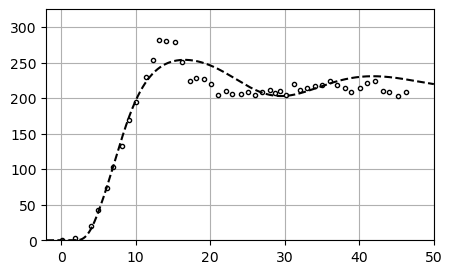

In [5]:
### EXP VALUES ###
msre_integral_worth = 'Data/msre_integral_rod_worth.csv'
msre_data = 'Data/msre_startup_datapoints.csv'

df = pd.read_csv(msre_integral_worth)
data = pd.read_csv(msre_data)

z = df['z'].values
rho = df[' rho'].values
pos = data['pos'].values
ornl_time_data = data['time'].values

values = np.interp(pos, z, rho)
base_insertion = values[0]
startup_base_insertion = values[0]

ornl_delta_rho_data = 1000*(values - base_insertion) # this is the data we calculated based on experimental values

# MAKE PLOT
plt.figure(figsize=(5,3))
plt.plot(ornl_time_data, ornl_delta_rho_data, 'ko', markerfacecolor='w', markersize=3)

### MY VALUES ###
x = np.array(list(beta_eff_dict_mc.keys()))
y_MC = beta_eff_dict_mc[-2.0] - np.array(list(beta_eff_dict_mc.values()))
plt.plot(x, y_MC*10**5, 'k--')
# plt.plot(x[0::50], y[0::50]*10**5, 'ks', markerfacecolor='w')
# plt.plot(x[0::50], y[0::50]*10**5, 'k+', markerfacecolor='w')

# OTHER PLOTTING STUFF
plt.grid()
plt.xlim([-2,50])
plt.ylim([0,325])




In [6]:
# End
print(ch.get_channel_residence_time())
print(upper_plenum.get_channel_residence_time())
print(external_loop.get_channel_residence_time())
print(lower_plenum.get_channel_residence_time())

8.741754430744814
2.0000035940168104
12.778594394143816
2.0000035940168104
